In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import j1, jv
import astropy.units as u
import matplotlib as mpl

# Plotting parameters
# usetex option per default disabled
my_rcParams = {
        #~ 'font.size': 10,
        'font.size': 10,
        'lines.linewidth': 1,
        'text.latex.preamble': r'\usepackage{amsmath} \usepackage{amssymb}',
        'text.usetex': False
}
mpl.rcParams.update(my_rcParams)

# Plot definitions
textwidth = 523.5307 / 72       # 1 inch = 72 pt
cm_in_inches = 1/2.54

# constants
planck_h = 6.62607015 * 10**-34  # Planck's constant (J·s)
light_c = 299792458  # Speed of light (m/s)
k_b = 1.380649 * 10**-23  # Boltzmann's constant (J/K)

In [2]:
# define observing wavelength and flux ratio
wave = np.array([3.4])
n_wave=len(wave)
star_to_point = 0.01

# define configuration coordinates (e.g., medium)
u_coord = np.array([33.63997455, -56.3677742,  -10.42834146,  23.21163309, -66.79611566,
 -33.15614111])/wave*10**6
v_coord = np.array([87.57970372, -35.35779227, -33.42869214,  54.15101158, -68.78648441,
  18.79321931])/wave*10**6

# Define stellar parameters and constants
dist = 21.0  # Distance in parsecs
R_star = 2.17  # Stellar radius in solar radii
radius_star_m = R_star * 6.957 * 10**8  # Convert to meters
dist_obs_to_star_m = dist * 3.086 * 10**16  # Convert parsecs to meters
T_eff = 6474  # Effective temperature in Kelvin
u_wave_arr = np.array([0.22])  # Limb-darkening coefficient

# define size=pixel number (increase for higher resolution) and field of view
size = 201 
fov = 0.2

# define instrument efficiency (off-axis)
instrument_efficiency_fwhm = 0.6     # in as

# Calculate visibilities

In [3]:
# function to determine complex visibility
def get_point_visibs(r_au,phi,dist):
    xx_au = r_au*np.sin(phi)
    yy_au = r_au*np.cos(phi)
    xPS    = (xx_au/dist)*np.pi/(3600.*180.)#rad
    yPS    = (yy_au/dist)*np.pi/(3600.*180.)#rad
    vis=np.exp(-2*np.pi*1j*(v_coord.reshape((-1,1))*xPS+u_coord.reshape((-1,1))*yPS))
    return vis

In [4]:
# calculate base line lengths 
B_plot = np.sqrt(u_coord**2 + v_coord**2)  # baselines in lambda
B_star = B_plot * wave / 10**6  # EBaselines in m

In [5]:
# Initialize result arrays
vis_star_arr = np.zeros((len(B_star), len(wave)))  # Adjusted array size
f_star_arr = np.zeros(len(wave))

# Compute visibility and flux density
for wave_idx, wave_val in enumerate(wave):
    # Stellar diameter in milliarcseconds
    stellar_diameter = 2 * R_star * 0.0046524726 / dist * 1000 * u.marcsec

    # Coefficient for visibility calculation
    coeff = (np.pi * stellar_diameter.to(u.rad).value * B_star) / (wave_val * 10**-6)

    # Planck function terms
    h1 = 2 * planck_h * light_c**2 / (wave_val * 10**-6)**5
    h2 = np.exp(planck_h * light_c / (k_b * wave_val * 10**-6 * T_eff)) - 1
    stellar_radiance_obs = h1 / h2

    # Stellar flux density calculation
    stellar_radiation = 4.0 * np.pi * (radius_star_m**2) * np.pi * stellar_radiance_obs
    stellar_flux_dens = (
        stellar_radiation / (4.0 * np.pi * dist_obs_to_star_m**2)
        * 1.0 * 10**26
        * ((wave_val * 10**-6)**2 / light_c)
    )

    # Visibility calculation
    vis_star = (
        (6 / (3 - u_wave_arr))
        * (
            ((1 - u_wave_arr) * (jv(1, coeff) / coeff))
            + (u_wave_arr * np.sqrt(np.pi / 2.0) * (jv(1.5, coeff) / coeff**1.5))
        )
    )

    # Store results
    vis_star_arr[:, wave_idx] = vis_star.flatten()  # Ensure correct shape
    f_star_arr[wave_idx] = stellar_flux_dens



In [6]:
np.log(2)

0.6931471805599453

In [7]:
# convert coordinates
v_star = (vis_star_arr*f_star_arr).reshape(-1)
sigma = instrument_efficiency_fwhm*dist / (2 * np.sqrt(2 * np.log(2)))

# Create a grid of points, then calculate and store visibilities and their phases
x = np.linspace(-fov, fov, size)
y = np.linspace(-fov, fov, size)
X, Y = np.meshgrid(x, y)
vis_all_list = []
phs = []
for i in range(size):
    for j in range(size):
        r_au = np.sqrt(X[i, j]**2 + Y[i, j]**2)  # Calculate the radial distance in AU
        phi = np.arctan2(X[i, j], Y[i, j])  # Calculate the angular position phi
        vis_as = get_point_visibs(r_au, phi, dist)  # Sum over visibilities
        gaussian_factor = np.exp(-(r_au**2) / (2 * sigma**2))
        v_p = (vis_as * star_to_point * f_star_arr * gaussian_factor).reshape(-1)
        vis_all = (v_p+v_star)/(star_to_point*f_star_arr*gaussian_factor+f_star_arr) # 
        ph = np.angle(vis_all, deg=False)
        vis_all = np.abs(vis_all)
        phs.append(ph)
        vis_all_list.append(vis_all)
vis_all_arr = np.array(vis_all_list)
vis_all_arr = vis_all_arr.reshape(size,size,-1)

# Calculate delta visibilities

In [8]:
# Calculate the pixel-wise absolute visibility difference 
vis_ds = v_star/f_star_arr
diff = np.abs(vis_all_arr - vis_ds)
max_diff = np.max(diff, axis=2)  # Average over the last dimension


# Calculate closure phases

In [9]:
# define triangles
# cl_triangle_idx contains the indices of the baselines forming the triangles
# with regard to the previously defined uv-coordinates
cl_triangle_idx = np.array([
    [2, 0, 3],  
    [1, 2, 4],  
    [1, 3, 5],  
    [4, 0, 5]   
])

# reshape phases of determined visibilities to shape (size, size, 6), 
# where 6 is the number of base lines
phs_ar = np.array(phs)
phs_ar = phs_ar.reshape(size, size, -1)  # Shape: (size, size, 6)

# Calculate closure phases for each pixel in the 2D grid (shape: (size, size, 4))
cl_phs = phs_ar[:, :, cl_triangle_idx[:, 0]] + \
         phs_ar[:, :, cl_triangle_idx[:, 1]] - \
         phs_ar[:, :, cl_triangle_idx[:, 2]]

# Ensure closure phases are in the range [-pi, pi]
cl_phs = np.mod(cl_phs + np.pi, 2 * np.pi) - np.pi

# determine maximum absolute value of closure phases over all base lines
max_cl = np.max(np.abs(cl_phs), axis=2)
max_cl = max_cl * 180 / np.pi

# cl_phs now has shape (size, size, 4) containing 4 closure phases for each pixel
print(cl_phs.shape)  # Output should be (size, size, 4)

(201, 201, 4)


# Plot Delta Visibility (i.e., visibility deficit)

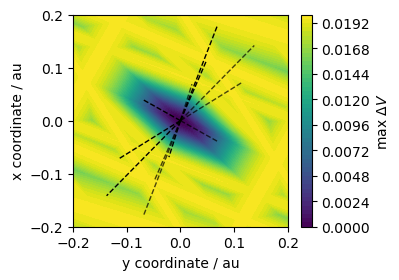

In [10]:
plt.figure(figsize=(8.8 * cm_in_inches,7 * cm_in_inches))
scaling_factor_plot = 7*10**-9

# plot the u-v baselines
for i in range(len(u_coord)):
    plt.plot([0, u_coord[i]*scaling_factor_plot], [0, v_coord[i]*scaling_factor_plot], color='black', linestyle='--')
    plt.plot([0, -u_coord[i]*scaling_factor_plot], [0, -v_coord[i]*scaling_factor_plot], color='black', linestyle='--', alpha=0.7)

# Customize plot appearance with axes
plt.xlabel('y coordinate / au')
plt.ylabel('x coordinate / au')
contour = plt.contourf(Y, X, max_diff, levels=50, cmap='viridis')

# Show the plot
plt.colorbar(contour, label=r'max $\Delta V$')
plt.show()


# Plot closure phases

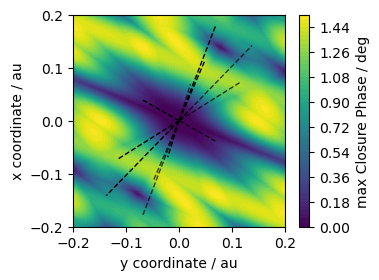

In [11]:
plt.figure(figsize=(8.8 * cm_in_inches,7 * cm_in_inches))
scaling_factor_plot = 7*10**-9

# Plot the scaled baseline lines
for i in range(len(u_coord)):
    plt.plot([0, u_coord[i]*scaling_factor_plot], [0, v_coord[i]*scaling_factor_plot], color='black', linestyle='--')
    plt.plot([0, -u_coord[i]*scaling_factor_plot], [0, -v_coord[i]*scaling_factor_plot], color='black', linestyle='--', alpha=0.7)

# Customize plot appearance
plt.xlabel('y coordinate / au')
plt.ylabel('x coordinate / au')
plt.gca().set_aspect('equal', adjustable='box')  # Keep aspect ratio square

# Plot the main contour for max_cl map
contour = plt.contourf(Y, X, max_cl, levels=50, cmap='viridis', alpha=1.0)

# Display colorbar for the main contour
cbar = plt.colorbar(contour, label=r'max Closure Phase / deg')
plt.show()


# Include Orbits, move companions along orbits

In [12]:
from orbit import Orbit, analyze_orbit_on_map
pixel_width = 2*fov/size

# Example usage: define orbit at 0.1 au
orbit_1 = Orbit(radius=0.1, 
                phi_0=0.0, 
                inclination=80.0, 
                position_angle=0.0, 
                star_mass=1.35)


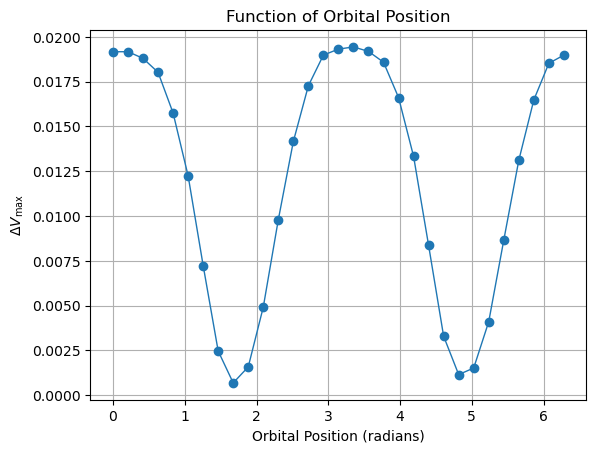

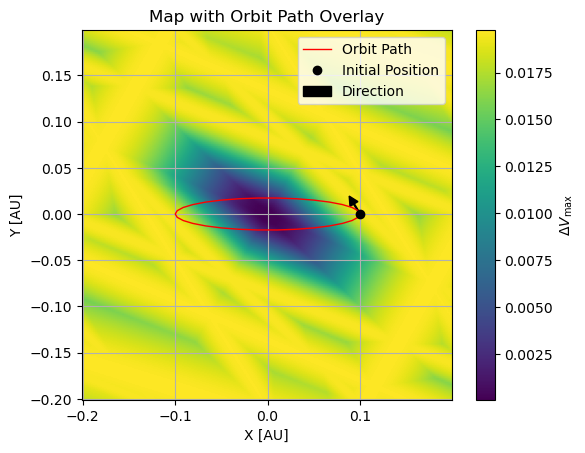

In [13]:
# Analyze orbit on delta visibility map
delta_vis_on_orbit = analyze_orbit_on_map(orbit_1, 
                     num_positions=31, 
                     pixel_width=pixel_width, 
                     sample_map=max_diff, 
                     arrow_scale= 3., 
                     label = r'$\Delta V_{\rm max}$')

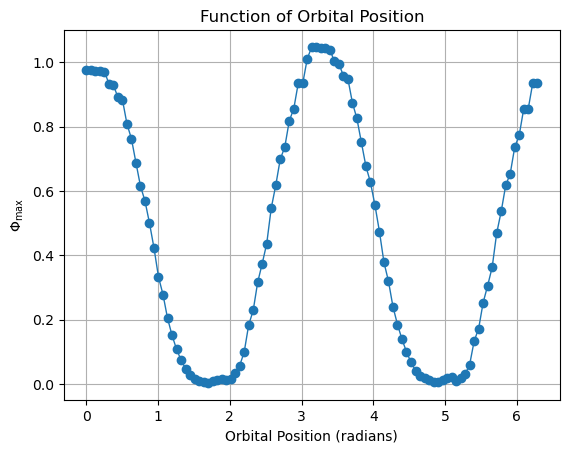

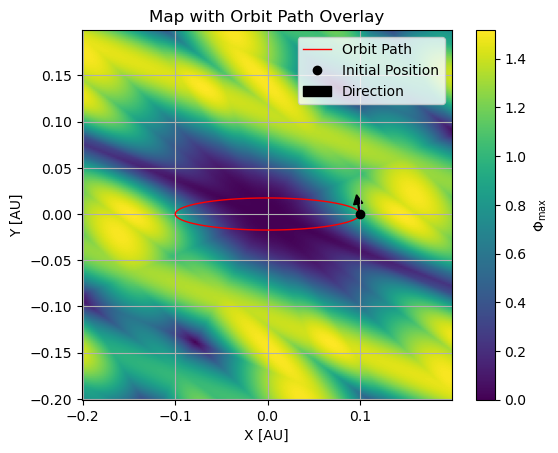

In [14]:
# Analyze orbit on maximal closure phase map
phases_on_orbit = analyze_orbit_on_map(orbit_1, 
                                       num_positions=101, 
                                       pixel_width=pixel_width, 
                                       sample_map=max_cl,
                                       label = r'$\Phi_{\rm max}$', 
                                       arrow_scale= 10.)
